# **Initialiser les données**

In [2]:
import os
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import cv2
import _3dpu_mehdi as mehdi
from _3dpu import *

In [3]:
!pip3 install ipympl
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
chemin = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\ph_1.nii"
chemin_mag = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\mag_1.nii"
chemin2 = r"C:\Users\0\Downloads\TGVQSM-plus\TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3\test_data\epi3d_test_phase.nii"
chemin3 = r"C:\Users\0\Downloads\20170327_qsm2016_recon_challenge\20170327_qsm2016_recon_challenge\data\phs_wrap.nii"
phase_image = nb.load(chemin)
mag_imgae = nb.load(chemin_mag)
phase_image2 = nb.load(chemin2)
phase_image3 = nb.load(chemin3)
x_min,x_max = 50,130
y_min,y_max = 50,130
z_min,z_max = 20,60
t = 1
data = phase_image.get_data()[:,:,:,t]
mag_data = mag_imgae.get_data()[:,:,:,t]
# data = phase_image2.get_data()
# data3 = phase_image3.get_data()

C:\Users\0\AppData\Local\Temp\ipykernel_16688\2482561751.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[:,:,:,t]
C:\Users\0\AppData\Local\Temp\ipykernel_16688\2482561751.py:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mag_data = mag_imgae.get_data()[:,:,:,t]


In [9]:
psi = data
shape = psi.shape
# Store the list of all residuals.
res = []
for a in range(dim):
    res.append(residuals(psi, a))
marker1 = {}
unprocess_all(res, marker1)
# r = unprocessed_residual(marker)
# l = search_loop(SpinnedResidual(1, r), shape, marker, False)
len(marker1.items())

1939371

# **La détection des contours**

In [10]:
blur = 21
canny_low = 15
canny_high = 150
min_area = 0.0005
max_area = 0.95
dilate_iter = 10
erode_iter = 10
mask_color = (0.0,0.0,0.0) 


def mask(im):
    mask = np.zeros(im.shape, dtype = np.uint8)

    edges = cv2.Canny(im, canny_low, canny_high)
    edges = cv2.dilate(edges,None)
    edges = cv2.erode(edges,None)

    l = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)



    if len(l[0]) > 0 :
        c = l[0][0]
        cv2.contourArea(c)
        contour_info = [(c, cv2.contourArea(c),) for c in l[0]]
        #create a mask to blok elements outside of la boulce
        
        max_area = 0.95 * im.shape[0] * im.shape[1]

        for contour in contour_info:
            # Instead of worrying about all the smaller contours, if the area is smaller than the min, the loop will break
            if contour[1] > min_area and contour[1] < max_area:
                # Add contour to mask
                mask = cv2.fillConvexPoly(mask, contour[0], (255))
        mask = cv2.dilate(mask, None, iterations=10)
        mask = cv2.erode(mask, None, iterations=10)


    return mask


In [7]:
M_z = np.empty(data.shape)
M_x = np.empty(data.shape)
M_y = np.empty(data.shape)

for x in range(data.shape[0]):
    M_x[x,:,:] = np.array(mag_data[x,:,:] > 10)

for y in range(data.shape[1]):
    M_y[:,y,:] = np.array(mag_data[:,y,:] > 10)

for z in range(data.shape[2]):
    M_z[:,:,z] = np.array(mag_data[:,:,z] > 10)


ValueError: could not broadcast input array from shape (208,96) into shape (80,40)

In [6]:
data = phase_image.get_data()[:,:,:,t]
M = mag_data
M = (M > 10)
data = data*M

C:\Users\0\AppData\Local\Temp\ipykernel_3864\1166997672.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[:,:,:,t]


In [7]:
data = phase_image.get_data()[:,:,:,t]
data = data * M_z
data = data * M_y
data = data * M_x

C:\Users\0\AppData\Local\Temp\ipykernel_3864\1718044037.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[:,:,:,t]


ValueError: operands could not be broadcast together with shapes (208,208,96) (80,80,40) 

In [4]:
#code _3dpu.py
import time
deb = time.time()
marker2 = {}
loops = []
l = residual_loops(loops,marker2,data)
fin = time.time()
print(fin-deb)


38.75603532791138


In [1]:
# plt.figure() 
d = np.array([len(l.loop) for l in loops])
filter = (d<20)
d = d*filter
np.argmax(d)

NameError: name 'np' is not defined

In [534]:
def f(x):
    return 3*x*x*(x-1) - 2*(x-1)*(x-1)*(x-1)
np.argmax(np.array([len(loop.loop) for loop in l]))

26

In [11]:
from numpy import *
s = SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 2, 76, 47])))

unprocess_all(res,marker1)
next_s = next_residual(s,marker1)
print(next_s)
marker1[next_s.res] = 1
next_s2 = next_residual(s,marker1)
print(next_s2)
marker1[next_s2.res] = 1
# next_s3 = next_residual(s,marker1)
# print(next_s3)
# marker1[next_s3.res] = 1

None


AttributeError: 'NoneType' object has no attribute 'res'

In [12]:
retrouve = next_s
k1 = 0
for i,loop in enumerate(loops):
    if SpinnedResidual(1,retrouve.res) in loop.loop:
        k1 = i
# unprocess_all(res,marker1)
# pos1 = loops[13].loop[0]
# d = search_loop(pos1,shape,marker1,True)

# for pos in d.loop:

#     print(pos,marker1[pos.res])
loop_ret =  loops[k1].loop
print(next_s)
print(np.array(loop_ret))

NameError: name 'loops' is not defined

In [9]:
retrouve = next_s2
k = 0
for i,loop in enumerate(loops):
    if SpinnedResidual(1,retrouve.res) in loop.loop:
        k = i
# unprocess_all(res,marker1)
# pos1 = loops[13].loop[0]
# d = search_loop(pos1,shape,marker1,True)

# for pos in d.loop:

#     print(pos,marker1[pos.res])
loop_ret2 =  loops[k].loop
print(next_s2)

print(np.array(loop_ret2))

AttributeError: 'NoneType' object has no attribute 'res'

In [29]:
from numpy import *
l1,l2 = [SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 7,  9, 49]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 7,  9, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 6, 10, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 7, 10, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 7, 10, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 7, 11, 47]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 7, 11, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 6, 11, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 6, 10, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 6,  9, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 6,  8, 48]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 6,  8, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 5,  9, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 5,  9, 48]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 5,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 5,  8, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 4,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 4,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 4,  9, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 4,  9, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 4,  9, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 4,  8, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 4,  8, 46]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 5,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 5,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 5,  8, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 5,  7, 45]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 5,  6, 45]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 4,  6, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([ 3,  7, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 3,  7, 46]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 3,  7, 46]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 2,  7, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 2,  7, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([ 2,  6, 48]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 2,  6, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 1,  6, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 1,  6, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 2,  6, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 2,  6, 46]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=-1, pos=array([ 2,  6, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([ 1,  6, 45]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 1,  5, 45]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([ 2,  5, 44])))],[SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 2,  5, 44]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 2,  6, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=2, ori=-1, pos=array([ 2,  6, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 2,  6, 43]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 3,  5, 43]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 3,  6, 43]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 3,  6, 44]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 3,  6, 44]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 4,  5, 44]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  6, 44]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  7, 44]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 4,  7, 45]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  8, 45]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 4,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 5,  8, 46]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 5,  9, 46]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 5,  9, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=1, ori=-1, pos=array([ 5,  9, 47]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([ 5,  8, 47]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4,  9, 47]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 4,  9, 48]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 4, 10, 48]))), SpinnedResidual(spin=-1, res=Residual(ax=0, ori=-1, pos=array([ 4, 10, 48]))), SpinnedResidual(spin=1, res=Residual(ax=1, ori=1, pos=array([ 3, 11, 48]))), SpinnedResidual(spin=1, res=Residual(ax=2, ori=1, pos=array([ 3, 11, 49])))]


In [10]:
a = [1,2,4,2]
len(set(a))

3

In [65]:
marker2[( Residual(ax=0, ori=1, pos=np.array([53, 69,  0])))]

KeyError: Residual(ax=0, ori=1, pos=array([53, 69,  0]))

In [15]:
s = SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=np.array([ 5, 34, 48])))



next_s = next_residual(s,marker1,False)

# for loop in loops:
#     print()
#     print(loop)

# loops[-2] = loops[-2][1]


In [9]:
v = SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=np.array([53, 68,  0])))

# search_loop(v,shape,marker2,True)

potential_neighbors(v,True)

[SpinnedResidual(spin=-1, res=Residual(ax=0, ori=1, pos=array([52, 68,  0]))),
 SpinnedResidual(spin=-1, res=Residual(ax=1, ori=1, pos=array([52, 68,  0]))),
 SpinnedResidual(spin=1, res=Residual(ax=1, ori=-1, pos=array([52, 69,  0]))),
 SpinnedResidual(spin=-1, res=Residual(ax=2, ori=1, pos=array([52, 68,  0]))),
 SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([52, 68,  1])))]

In [100]:
pos = SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=np.array([ 5, 33, 49])))
unprocess_all(res,marker1)
search_loop(pos,shape,marker1)

FlaggedLoop(closed=False, loop=[SpinnedResidual(spin=1, res=Residual(ax=2, ori=-1, pos=array([ 5, 33, 49])))])

In [258]:
# l =np.array([len(loop.loop) for loop in loops])
l


array([ 1,  1,  1, ..., -1, -1, -1])

In [8]:
def next_residual(curr: SpinnedResidual, marker: ResidualMarker, reverse: bool = False, shuffle: bool = True):
    # List of potential neighbors.
    neighbors = potential_neighbors(curr, reverse)
    l = []
    # Shuffle the list of neighbors if asked to.
    if shuffle:
        random.shuffle(neighbors)

    # Look for the first neighbor that has not been
    # yet processed.
    for spinned_residual in neighbors:
        if spinned_residual.res in marker and marker[spinned_residual.res] == -1:
            l.append(spinned_residual)

    # Return None.
    return l

In [29]:
(marker2.values())

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
def potential_neighbors(self: SpinnedResidual) -> list[SpinnedResidual]:
    # List of potential neighbors.
    neighbors = []
    # Add the neighbor with the same axis as
    # the current residual.
    npos = deepcopy(self.res.pos)
    npos[self.res.ax] += self.spin
    neighbors.append(SpinnedResidual(self.spin, Residual(self.res.ax, self.res.ori, npos)))

    # Add the neighbors for other axes.
    for d in range(1, dim):
        na = (self.res.ax + d) % dim
        if self.spin == 1:
            for i, ns in zip([0, 1], [-1, 1]):
                npos = deepcopy(self.res.pos)
                npos[na] += i*self.spin
                neighbors.append(SpinnedResidual(ns, Residual(na, self.res.ori * ns, npos)))
        if self.spin == -1:
            for i, ns in zip([0, 1], [1, -1]):
                npos = deepcopy(self.res.pos)
                npos[na] += i
                npos[self.res.ax] -= 1
                neighbors.append(SpinnedResidual(self.spin*ns, Residual(na, self.res.ori * ns, npos)))
    return neighbors

(15.0, 19.0)

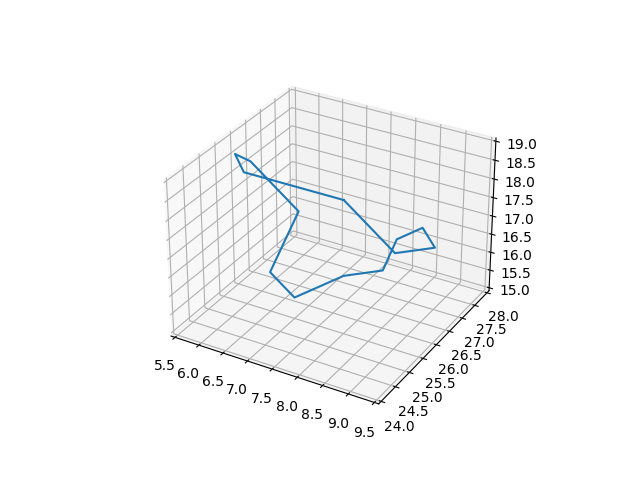

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X = []
Y = []
Z = []
for loop in loops[92:92+1]:
    if True:
        lasso_positions = []
        for r in loop.loop:
            pos = [r.res.ax] + list(r.res.pos)
            if pos[0] == 2:
                new_pos = [pos[1]+0.5,pos[2] + 0.5,pos[3]]
            elif pos[0] == 1:
                new_pos = [pos[1]+0.5,pos[2],pos[3]+0.5]
            elif pos[0] == 0:
                new_pos = [pos[1],pos[2] + 0.5,pos[3]+0.5]
                
            lasso_positions.append(new_pos)
        xs = [pos[0] for pos in lasso_positions]
        ys = [pos[1] for pos in lasso_positions]
        zs = [pos[2] for pos in lasso_positions]
        xs = xs 
        ys = ys 
        zs = zs 
        ax.plot(xs,ys,zs)
        Z = Z + zs
        X = X + xs
        Y = Y + ys

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)



4

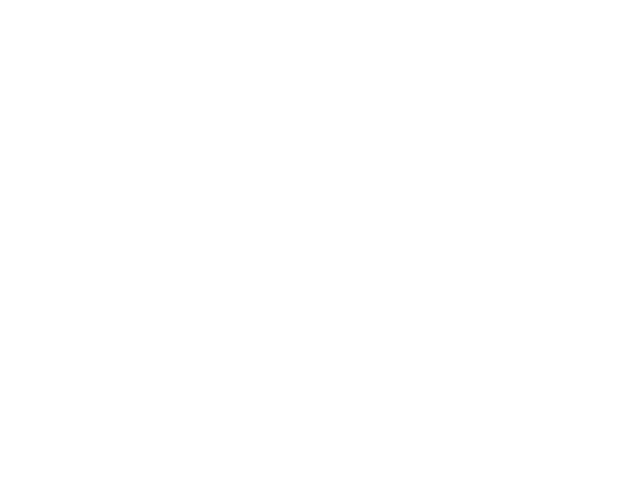

In [23]:
a = plt.figure()
d = np.array([len(l.loop) for l in loops])
np.argmax(d)
# plt.hist(d,bins=100)
# plt.show()
# np.quantile(d,0.96)
d[250]

In [24]:
marker = marker2
unprocess_all(res,marker)
r = Residual(ax=0, ori=1, pos=np.array([ 0, 76,  1]))
d = search_loop(SpinnedResidual(1, r), shape, marker, False)

SpinnedResidual(spin=1, res=Residual(ax=0, ori=1, pos=array([ 0, 76,  1])))

False


ValueError: 

In [78]:
#Analyze Magnitude
chemin_mag = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\mag_1.nii"
mag_imgae = nb.load(chemin_mag)
t = 15
mag_data = mag_imgae.get_data()[:,:,:,t]



C:\Users\0\AppData\Local\Temp\ipykernel_3116\236111063.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mag_data = mag_imgae.get_data()[:,:,:,t]


# **3DPU**

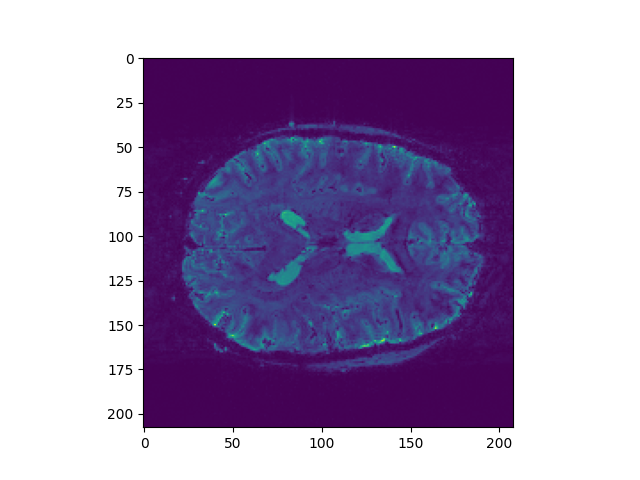

In [80]:
fig2 = plt.figure()
plt.imshow(mag_data[:,:,45])

In [26]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [81]:

from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [28]:

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [29]:

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [30]:

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

C:\Users\0\AppData\Local\Temp\ipykernel_3116\3311171020.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
C:\Users\0\AppData\Local\Temp\ipykernel_3116\3311171020.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


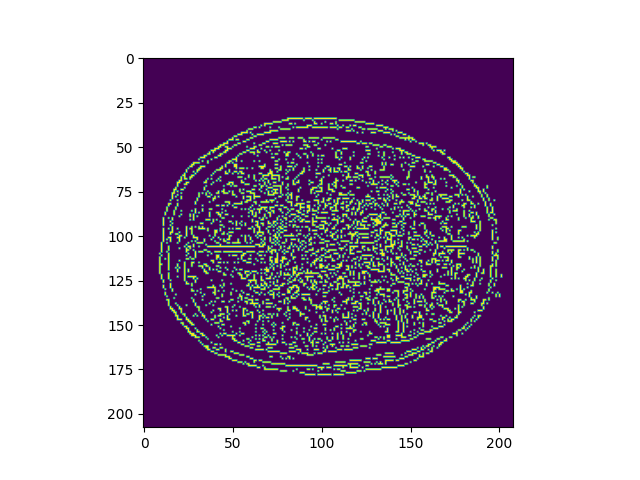

In [31]:
img = mag_data[:,:,46]


G,D = sobel_filters(img)

Z = non_max_suppression(img,D)

res,weak,strong = threshold(Z)

hys = hysteresis(res,weak,strong)
hys = hys / 255
plt.imshow(hys)
plt.show()



C:\Users\0\AppData\Local\Temp\ipykernel_3116\3311171020.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
C:\Users\0\AppData\Local\Temp\ipykernel_3116\3311171020.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


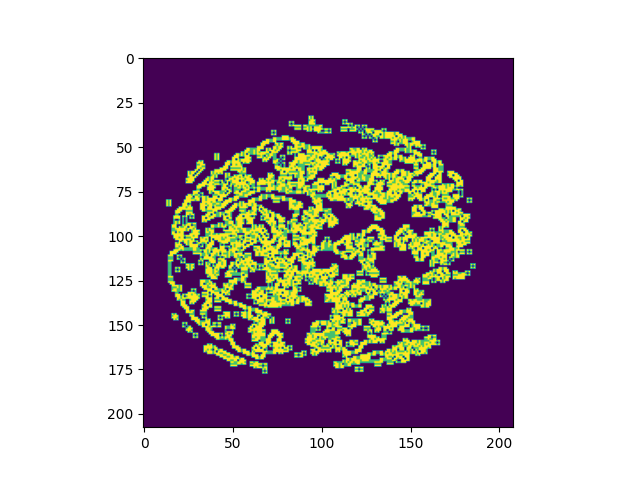

In [83]:
fig3 = plt.figure()
img = mag_data[:,:,25]
M = np.array(img)
M = (M > 20)
G,D = sobel_filters(M)
plt.imshow(G)
plt.show()

In [69]:
Val = G.reshape((208*208))
set(Val.tolist())


{0.0, 180.25, 255.0}

In [60]:
import cv2
import numpy as np
img = np.random.random((40,40))
im = np.array(img).astype(np.uint8)
contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [61]:
import os
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import cv2
chemin_mag = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\mag_1.nii"
mag_image = nb.load(chemin_mag)
t = 15


mag_data = mag_image.get_data()[:,:,:,t]
img = np.array(mag_data[:,:,40])

_, binary = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY_INV)

img = img
im = img.astype(np.uint8)


C:\Users\0\AppData\Local\Temp\ipykernel_3116\2272218081.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mag_data = mag_image.get_data()[:,:,:,t]


C:\Users\0\AppData\Local\Temp\ipykernel_3116\2738125725.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[:,:,:,t]


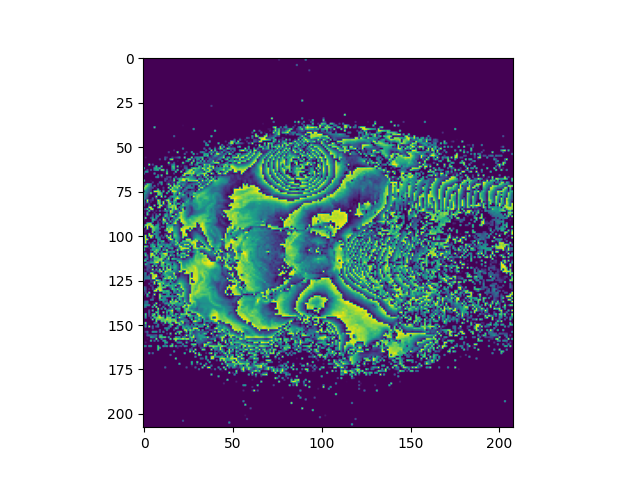

In [67]:
fig_1 = plt.figure()
data = phase_image.get_data()[:,:,:,t]
z = 10
b = (np.array(mag_data[:,:,z]).astype(np.uint8) > 1)

plt.imshow(b*np.array(data[:,:,z]))
plt.show()



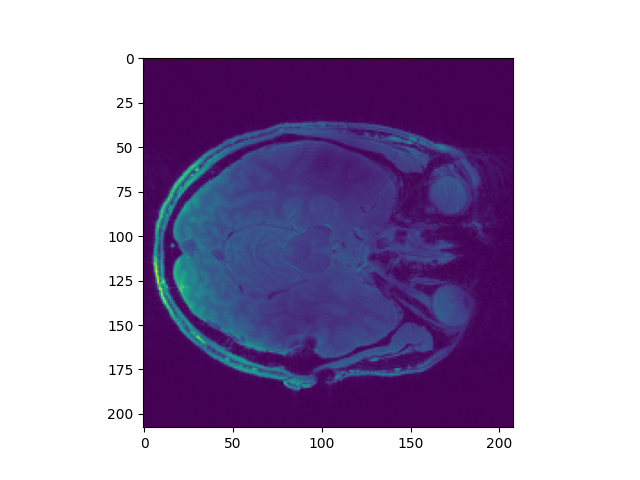

In [207]:
fig_2 = plt.figure()
plt.imshow(np.array(mag_data[:,:,z]))
plt.show()

# **Neural Pre-precossing**

In [6]:
!pip install npp

ERROR: Could not find a version that satisfies the requirement npp (from versions: none)
ERROR: No matching distribution found for npp

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
